# Neural learning with tensor flow

In [1]:
# Importing packages

import json
import numpy as np

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [2]:
# Set data setup

image_size = (224, 224)
batch_size = 32

In [3]:
# Set dataset train

train_ds = tf.keras.preprocessing.image_dataset_from_directory("C:/Users/pawel/Desktop/tensor/Data/Derm_neural_network_folder_test/train/",
                                                                  image_size=image_size, batch_size=batch_size,color_mode="rgb")

Found 31480 files belonging to 7 classes.


In [4]:
# Set dataset validation

val_ds = tf.keras.preprocessing.image_dataset_from_directory("C:/Users/pawel/Desktop/tensor/Data/Derm_neural_network_folder_test/val/",
                                                                  image_size=image_size, batch_size=batch_size,color_mode="rgb")

Found 1208 files belonging to 7 classes.


In [5]:
# Set dataset test

test_ds = tf.keras.preprocessing.image_dataset_from_directory("C:/Users/pawel/Desktop/tensor/Data/Derm_neural_network_folder_test/test/",
                                                                  image_size=image_size, batch_size=batch_size,color_mode="rgb")

Found 1008 files belonging to 7 classes.


(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 224, 224, 3)


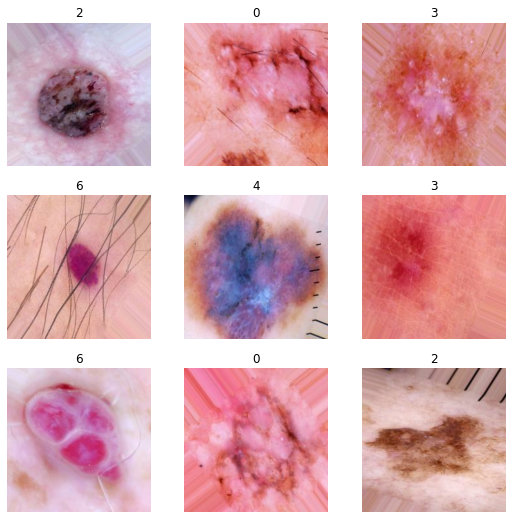

In [6]:
# Plot pictures of data 

plt.figure(figsize=(9, 9))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
#         plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")
        print(images.shape)

In [7]:
# Set autotiune vor dataset

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [8]:
# Labels for data

labels_types={"Choroba Bowena(akiec)" : 0, "Rak podstawnokomórkowy(bcc)" : 1, "Łagodne zmiany przypominające rogowacenie(bkl)" : 2, "Dermatofibroma(df)" : 3, "Czerniak(mel)" : 4, "Znamiona melanocytowe(nv)" : 5, "Zmiany naczyniowe(vasc)" : 6}

In [9]:
# Callback for testing data

save_callback = tf.keras.callbacks.EarlyStopping(patience=2)

# Transfer learning

In [10]:
# Transfer learning model

base_model = tf.keras.applications.ConvNeXtTiny(
    model_name="convnext_tiny",
    include_top=True,
    include_preprocessing=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

base_model.trainable = False

In [11]:
# Build full model with layers to interprate pictures

model = tf.keras.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    base_model,
    tf.keras.layers.Dense(7)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_tiny (Functional)  (None, 1000)              28589128  
                                                                 
 dense (Dense)               (None, 7)                 7007      
                                                                 
Total params: 28,596,135
Trainable params: 7,007
Non-trainable params: 28,589,128
_________________________________________________________________


In [12]:
# Model compile

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# Fit model with 3 epochs

initial_epochs=3

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds, callbacks=save_callback)

Epoch 1/3
984/984 [==============================] - 13481s 14s/step - loss: 0.9286 - accuracy: 0.6542 - val_loss: 1.0225 - val_accuracy: 0.6300
Epoch 2/3
984/984 [==============================] - 13159s 13s/step - loss: 0.7313 - accuracy: 0.7285 - val_loss: 0.9489 - val_accuracy: 0.6440
Epoch 3/3
984/984 [==============================] - 13153s 13s/step - loss: 0.6750 - accuracy: 0.7483 - val_loss: 1.0050 - val_accuracy: 0.6341


In [14]:
# Save fiting history to json

history_dict = history.history
json.dump(history_dict, open("./History/history_dict.json", 'w'))


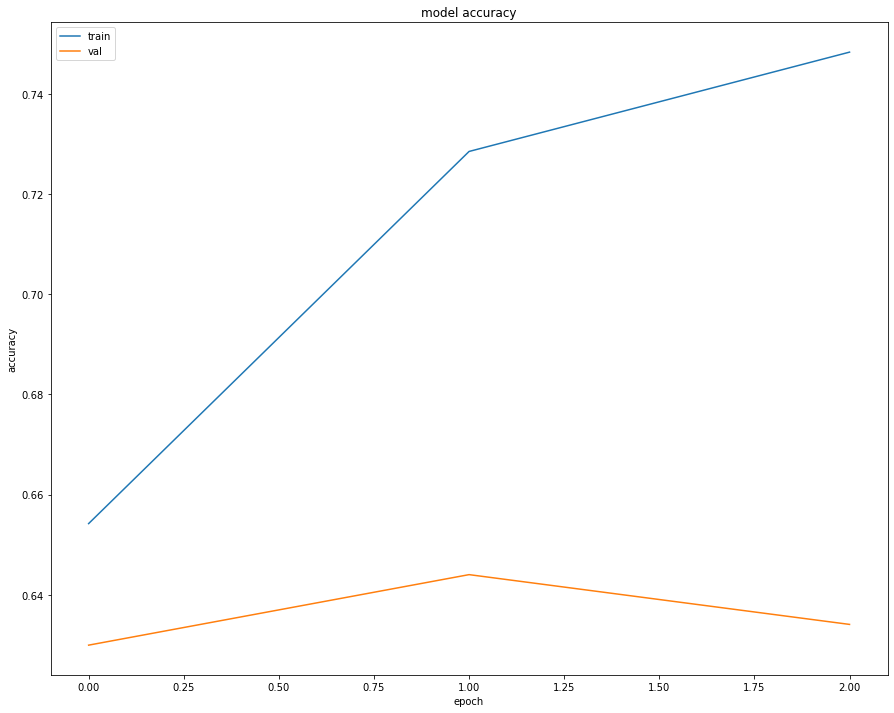

In [15]:
# Plot fiting stats

plt.figure(figsize = (15,12))
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
# Evaluate fited model

results = model.evaluate(test_ds)
print("test loss, test acc:", results)

38/38 [==============================] - 483s 13s/step - loss: 1.0050 - accuracy: 0.6341
test loss, test acc: [1.0049833059310913, 0.6341059803962708]


In [17]:
# Save model to tf file

model.save('model_tf')

INFO:tensorflow:Assets written to: model_tf\assets


INFO:tensorflow:Assets written to: model_tf\assets


In [18]:
# Load saved model

model_load = load_model('model_tf')

In [19]:
# Summary loaded model

model_load.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_tiny (Functional)  (None, 1000)              28589128  
                                                                 
 dense (Dense)               (None, 7)                 7007      
                                                                 
Total params: 28,596,135
Trainable params: 7,007
Non-trainable params: 28,589,128
_________________________________________________________________


In [20]:
# Test evaluate results

results = model_load.evaluate(test_ds)
print("test loss, test acc:", results)

38/38 [==============================] - 474s 12s/step - loss: 1.0050 - accuracy: 0.6341
test loss, test acc: [1.0049833059310913, 0.6341059803962708]


In [21]:
# Predictions for test data

predictions = model_load.predict(test_ds)

38/38 [==============================] - 489s 13s/step


<Figure size 1080x864 with 0 Axes>

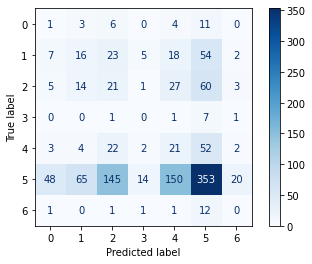

In [22]:
# Plot matrix 

plt.figure(figsize = (15,12))

predicted_categories = tf.argmax(predictions, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

# Custom neural network

In [23]:
# Building custom neural network and compile

num_classes = 7

model_cust = tf.keras.Sequential([
  tf.keras.layers.Conv2D(224, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(224, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(224, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])
 
model_cust.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
history_cust = model_cust.fit(train_ds, epochs=5, validation_data=val_ds, callbacks=save_callback)

Epoch 1/5
984/984 [==============================] - 4200s 4s/step - loss: 4.4783 - accuracy: 0.1483 - val_loss: 1.9425 - val_accuracy: 0.1805
Epoch 2/5
984/984 [==============================] - 4198s 4s/step - loss: 1.9967 - accuracy: 0.1449 - val_loss: 1.9395 - val_accuracy: 0.0265
Epoch 3/5
984/984 [==============================] - 4191s 4s/step - loss: 1.9413 - accuracy: 0.1464 - val_loss: 1.9403 - val_accuracy: 0.0265
Epoch 4/5
984/984 [==============================] - 4190s 4s/step - loss: 1.9406 - accuracy: 0.1456 - val_loss: 1.9422 - val_accuracy: 0.0265


In [24]:
# Save fiting history to json

history_dict = history_cust.history
json.dump(history_dict, open("./History/history_dict_cust.json", 'w'))

In [26]:
# Plot fiting stats

plt.figure(figsize = (15,12))
# summarize history for accuracy
plt.plot(history_cust.history['accuracy'])
plt.plot(history_cust['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

AttributeError: 'dict' object has no attribute 'history'

<Figure size 1080x864 with 0 Axes>

In [ ]:
# Evaluate fited model

results_cust = model_cust.evaluate(test_ds)
print("test loss, test acc:", results)

In [ ]:
# Save model to tf file

model.save('model_cust_tf')

In [ ]:
# Load saved model

model_cust_load = load_model('model_cust_tf')

In [ ]:
# Summary loaded model

model_cust_load.summary()

In [ ]:
# Test evaluate results

results = model_cust_load.evaluate(test_ds)
print("test loss, test acc:", results)

In [ ]:
# Predictions for test data

predictions_cust = model_cust_load.predict(test_ds)

In [ ]:
# Plot matrix 

plt.figure(figsize = (15,12))

predicted_categories = tf.argmax(predictions_cust, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0)

cm = confusion_matrix(predicted_categories, true_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

# Predict your picture

In [ ]:
img_width, img_height = 224, 224
img = tf.keras.preprocessing.image.load_img('./Data/Derm_neural_network_folder/df/ISIC_0024318.jpg', target_size = (img_width, img_height))
img = tf.keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

model_load.predict(img)

# Summary of project

Learning neural network on different numbers of pictures in each class is bad because your neural network learn to predict only one class. It leads to wrong evaluate metrics. In other way if you create a lot new pictures from "Data generator" you increase learning time. Maybe if you create more epoch you can get more accurate model. But as i see the validation accuracy decreas by second epoch.